<a href="https://colab.research.google.com/github/RobDrie/ML-TS/blob/main/00_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Home assignment

* Author: Romain Tavenard (@rtavenar)
* License: CC-BY-NC-SA

A home assignment from a course on Machine Learning for Time Series at ENSAI.
One can find lecture notes for this course [there](https://rtavenar.github.io/ml4ts_ensai/).

## Problem statement

The dataset we are interested in here is called "TwoPatterns". It is described [in this page](http://www.timeseriesclassification.com/description.php?Dataset=TwoPatterns) and can be downloaded using `tslearn`'s `load_dataset` utility, as seen in previous labs.

You should load the data and analyze it under several angles:

1. visualize the dataset (or a few time series from the dataset) to understand whether you expect time-shift-invariant methods to perform well on this dataset or not ;
2. compare time-shift-invariant methods to their time-shift-sensitive counterparts for the following tasks, and conclude:
    * clustering ;
    * supervised classification ;
    * forecasting (suppose you have to forecast the second half of the series with the first half provided as input).

It is not asked here that you implement specific layers / methods by yourself, but rather that you use established implementations of the methods you need.
Your focus should rather be on:
* data visualization,
* model architecture (for deep networks),
* experiment design,
* result analysis

## Deadline

Deadline for this home assignment is February 23th, 2024.
You should use the link on moodle to hand in your assignment.
A single ipynb file should be provided,
with execution traces.
This assignment is to be done **by groups of two, at most** and names of both students should be included in the file name.

In [2]:
!pip install tslearn
!pip install keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 5.5 MB/s eta 0:00:00


# Section 1 Data Visualization

### Load the data and show the dimensions

In [3]:
from tslearn.datasets import UCR_UEA_datasets
from keras.utils import to_categorical

X_train, y_train, X_test, y_test = UCR_UEA_datasets().load_dataset("TwoPatterns")
#print(X_train.shape)

y_train_cat = to_categorical(y_train - 1)
y_test_cat = to_categorical(y_test - 1)
print(f"X_train shape: {X_train.shape}, y_train.shape: {y_train.shape}, y_train_cat.shape: {y_train_cat.shape}, y_test_cat.shape: {y_test_cat.shape}")

num_categories = y_train_cat.shape[-1]

X_train shape: (1000, 128, 1), y_train.shape: (1000,), y_train_cat.shape: (1000, 4), y_test_cat.shape: (4000, 4)


### Plot a selection of time series for each class, together with the subplots

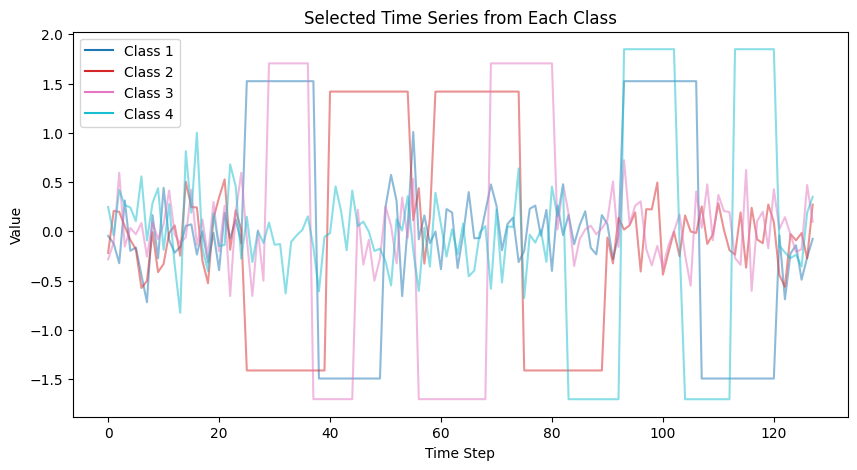

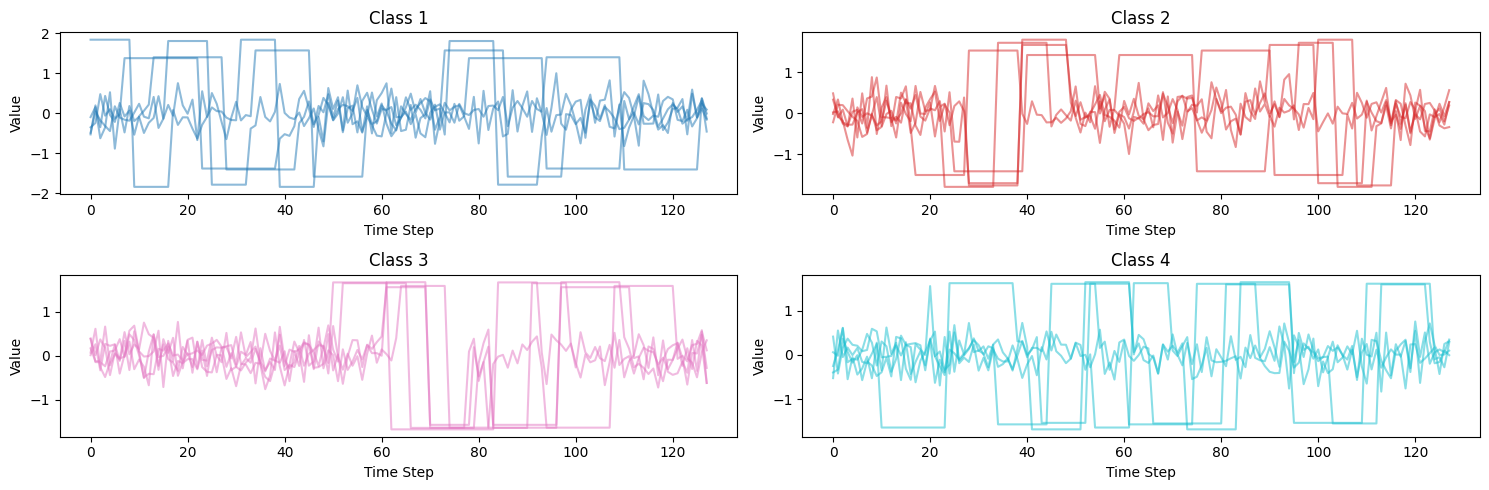

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_selected_classes(X_train, y_train, num_samples_per_class=10):
    unique_classes = np.unique(y_train)
    num_classes = len(unique_classes)
    colors = plt.cm.tab10(np.linspace(0, 1, num_classes))

    fig, ax = plt.subplots(figsize=(10, 5))

    for idx, cls in enumerate(unique_classes):
        class_indices = np.where(y_train == cls)[0]
        sample_indices = np.random.choice(class_indices, num_samples_per_class, replace=False)

        # Plot all selected samples for this class at once
        for sample_idx in sample_indices:
            ax.plot(X_train[sample_idx], color=colors[idx], alpha=0.5)

        # Add a legend entry for this class
        ax.plot([], [], color=colors[idx], label=f'Class {cls}')

    ax.legend()
    plt.title('Selected Time Series from Each Class')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.show()


def plot_selected_classes_subplots(X_train, y_train, num_samples_per_class=10):
    unique_classes = np.unique(y_train)
    num_classes = len(unique_classes)
    colors = plt.cm.tab10(np.linspace(0, 1, num_classes))

    # Calculate the number of rows needed for subplots based on the number of classes
    num_rows = int(np.ceil(num_classes / 2))  # Adjust the denominator to control how many columns you want
    fig, axs = plt.subplots(num_rows, 2, figsize=(15, num_rows * 2.5), squeeze=False)

    for idx, cls in enumerate(unique_classes):
        class_indices = np.where(y_train == cls)[0]
        sample_indices = np.random.choice(class_indices, num_samples_per_class, replace=False)

        # Determine which subplot to use
        row = idx // 2
        col = idx % 2
        ax = axs[row, col]

        for sample_idx in sample_indices:
            ax.plot(X_train[sample_idx], color=colors[idx], alpha=0.5)

        ax.set_title(f'Class {cls}')
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Value')

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()


plot_selected_classes(X_train, y_train, 1)
plot_selected_classes_subplots(X_train, y_train, 5)

### Question: Do we expect time-invariant methods to perform well on this dataset?

### Answer:
The time series for each class show noisy curves with sudden level increases at different times. There seems to be two types of curves within each class, one with many small variations around 0 and one with more stable values but with sharp level shifts. When comparing the different classes some patterns can be recognized in the time series with sharp level shifts, but observed at different time steps. Therefore, it is expected that time-shift invariant methods might be able to perform well in terms of clustering time series that are shifted across time. However, in terms of predictions, the time-shift sensitive methods are expected to perform better

In this report, the folloing metrics are analysed for the different methods:
-  Time-shift invariant method: soft-dtw
-  Time-shift sensitive method: euclidean

## Section 2 Comparing time-shift invariant and sensitive methods

The time-shift invariant and sensitive methods are compared on the following tasks:
* 2.1 clustering ;
* 2.2 supervised classification ;
* 2.3 forecasting ;





#### 2.1 TimeSeriesKMeans clustering with Euclidean distance metric and Soft-dtw distance metric

In [5]:
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tqdm.notebook import tqdm
import multiprocessing

# Function to evaluate clustering quality
def evaluate_clustering(X_train_scaled, params):
    n_clusters = params['n_clusters']
    metrics = params['metric']
    gamma = params['gamma']

    # Fit the model and predict clusters in one step
    km = TimeSeriesKMeans(n_clusters=n_clusters, metric=metrics, metric_params={"gamma": gamma}, n_jobs=multiprocessing.cpu_count() * 2 // 3, random_state=0)
    y_pred = km.fit_predict(X_train_scaled)

    # Compute the silhouette score
    score = silhouette_score(X_train_scaled, y_pred, metric=metrics, metric_params={"gamma": gamma})

    return {'n_clusters': n_clusters, 'gamma': gamma, 'score': score, 'metric': metrics}


In [ ]:
# Preprocess the time series data
scaler = TimeSeriesScalerMeanVariance()
X_train_scaled = scaler.fit_transform(X_train)

sample_size = 50  # Adjust this value to your desired sample size
random_indices = np.random.choice(X_train_scaled.shape[0], sample_size, replace=False)
X_train_sample = X_train_scaled[random_indices]

# Define parameter grid for grid search
param_grid = [{'n_clusters': n_clusters, 'gamma': gamma, 'metric': metric} for n_clusters in range(2, 5) for gamma in [0.01, 0.1, 1, 10] for metric in ['euclidean', 'softdtw']]

# Perform grid search with tqdm progress bar using list comprehension
results = [evaluate_clustering(X_train_sample, params) for params in tqdm(param_grid, desc="Grid search progress")]


# Find the best parameters
best_params = max(results, key=lambda x: x['score'])
best_metric = best_params['metric']
best_n_clusters = best_params['n_clusters']
best_gamma = best_params['gamma']
best_score = best_params['score']

print(f"Best metric: {best_metric}")
print(f"Best number of clusters: {best_n_clusters}")
print(f"Best gamma for soft-DTW: {best_gamma}")
print(f"Best silhouette score: {best_score}")


Grid search progress:   0%|          | 0/24 [00:00<?, ?it/s]

In [29]:
# Fit the final model with the best parameters
final_km = TimeSeriesKMeans(n_clusters=best_n_clusters,
                            metric=best_metric,
                            metric_params={"gamma": best_gamma},
                            verbose=1,
                            random_state=0)
final_km.fit(X_train_sample)



# Fit a final model with the best number of clusters according to the euclidean distance
euclidean_results = [result for result in results if result['metric'] == 'euclidean']
best_params_euclidean = max(euclidean_results, key=lambda x: x['score'])
best_n_clusters_euclidean = best_params_euclidean['n_clusters']

final_km_euclidean = TimeSeriesKMeans(n_clusters= best_n_clusters_euclidean,
                            metric='euclidean',
                            metric_params={"gamma": best_gamma},
                            verbose=1,
                            random_state=0)
final_km_euclidean.fit(X_train_sample)




# Plot the barycenters
# plt.figure(figsize=(10, 5))
# for i in range(best_n_clusters):
#     plt.plot(final_km.cluster_centers_[i], label=f'Barycenter {i+1}')
# plt.legend()
# plt.title('Barycenters of the clusters')
# plt.xlabel('Time Step')
# plt.ylabel('Value')
# plt.show()

483.685 --> 100.270 --> 87.896 --> 79.768 --> 79.749 --> 79.753 --> 79.688 --> 79.691 --> 79.685 --> 79.671 --> 79.658 --> 79.613 --> 79.640 --> 79.581 --> 79.602 --> 79.561 --> 79.577 --> 79.550 --> 79.568 --> 79.546 --> 79.560 --> 79.546 --> 79.552 --> 79.542 --> 79.547 --> 79.539 --> 79.543 --> 79.537 --> 79.540 --> 79.535 --> 79.538 --> 79.533 --> 79.536 --> 79.532 --> 79.535 --> 79.531 --> 79.534 --> 79.530 --> 79.533 --> 79.529 --> 79.532 --> 79.529 --> 79.531 --> 79.528 --> 79.531 --> 79.528 --> 79.531 --> 79.528 --> 79.530 --> 79.528 --> 
179.599 --> 103.838 --> 102.610 --> 102.280 --> 102.280 --> 


TimeSeriesKMeans(metric_params={'gamma': 0.01}, random_state=0, verbose=1)

### Visualization of the results for Soft-dtw and Euclidean centers and


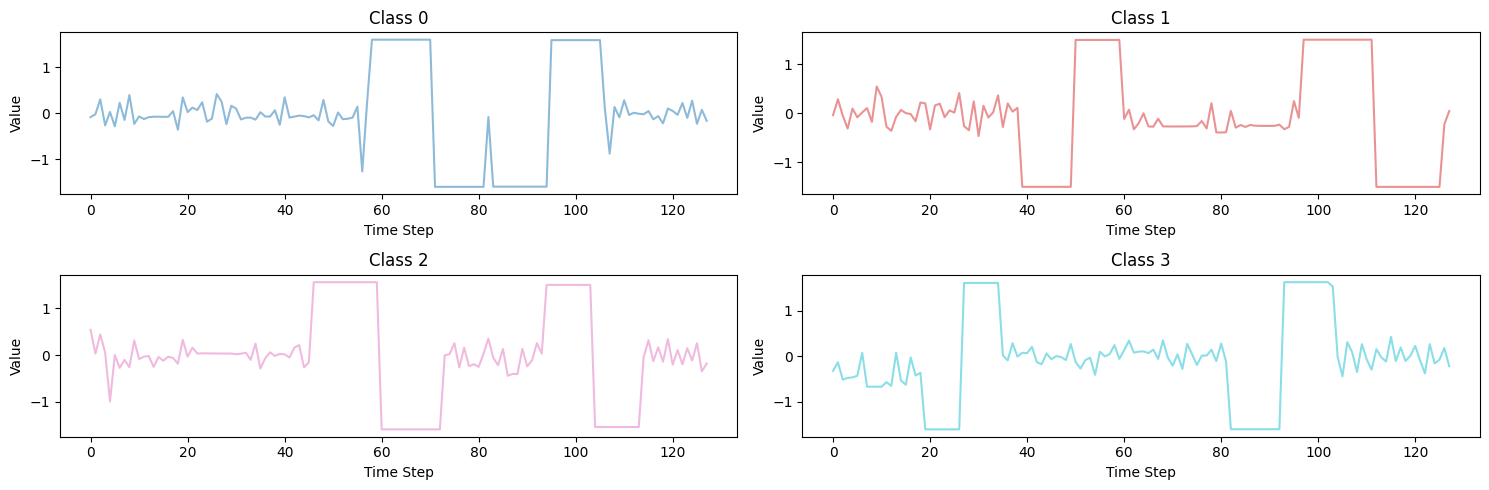

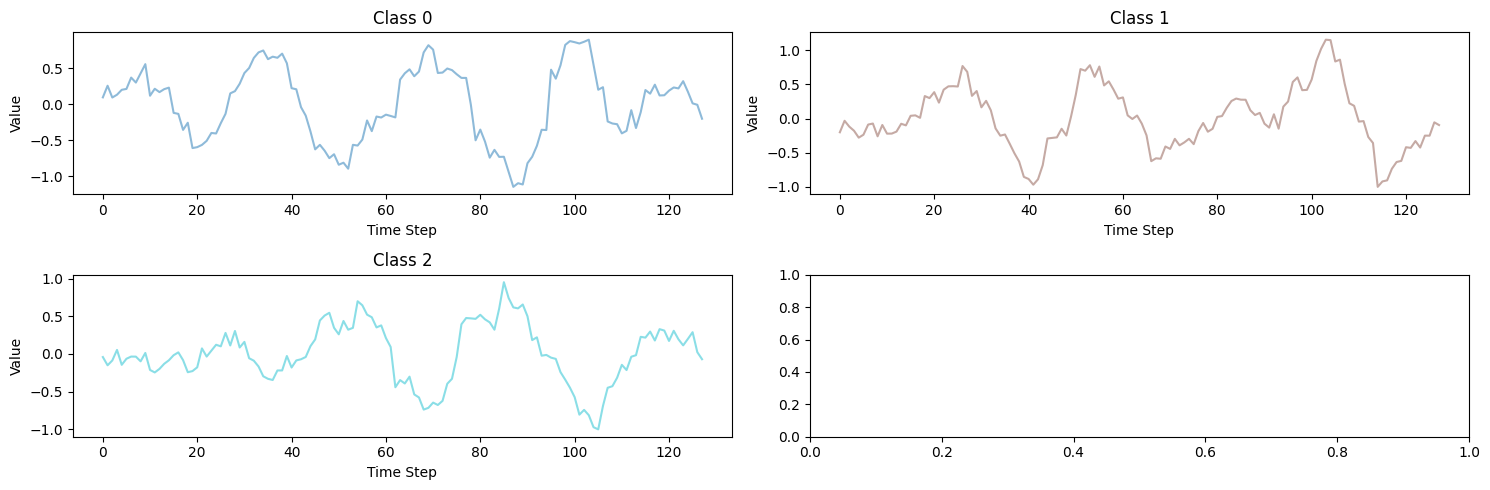

In [40]:
# Centers obtained by fitting a model with the best parameters as found with the soft-dtw metric
plot_selected_classes_subplots(final_km.cluster_centers_, list(range(final_km.n_clusters)), 1)

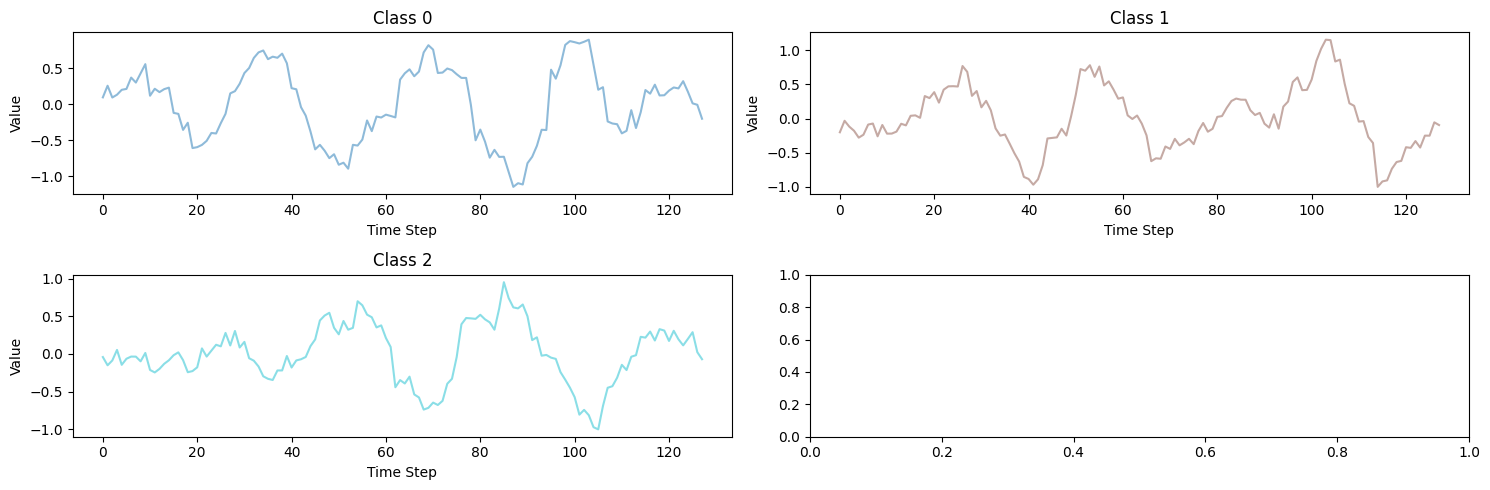

In [41]:
# Centers obtained by fitting a model with the best parameters as found with the Euclidean metric
plot_selected_classes_subplots(final_km_euclidean.cluster_centers_, list(range(final_km_euclidean.n_clusters)), 1)


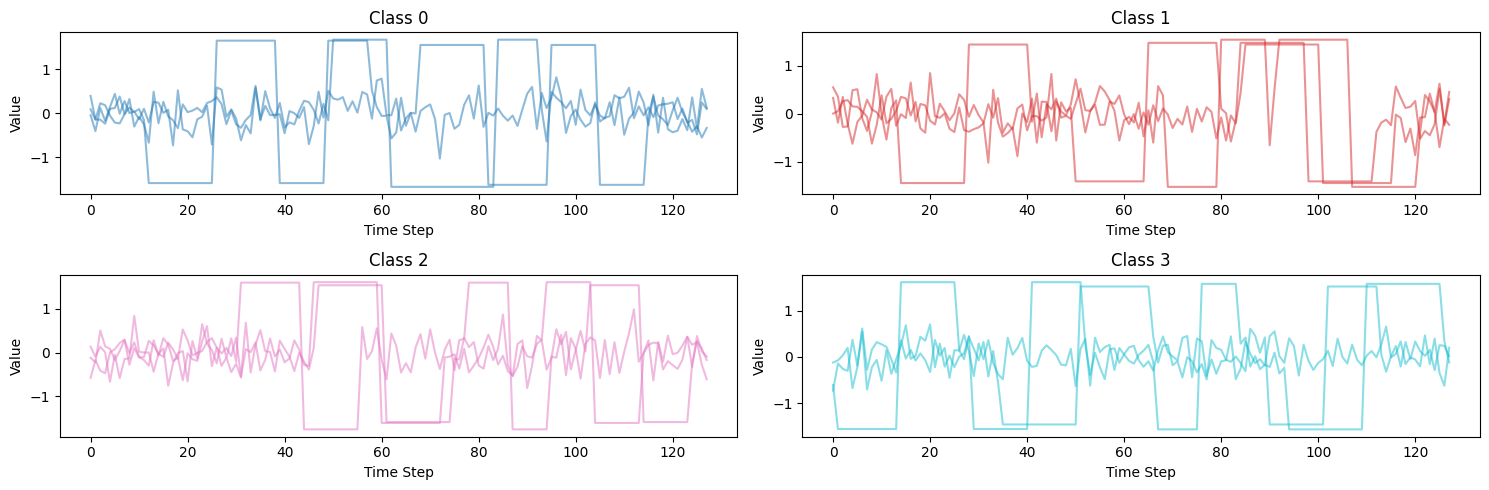

In [39]:
# Subset of the clustering as obtained with the best soft-dtw parameters
plot_selected_classes_subplots(X_train_sample, final_km.labels_, 3)

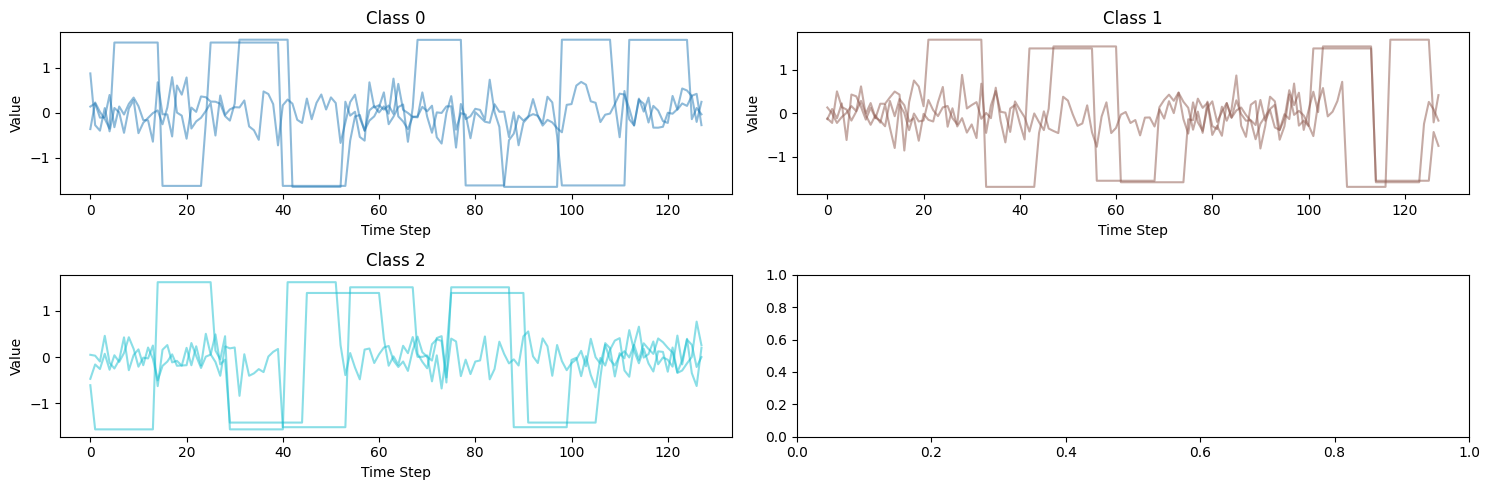

In [38]:
# Subset of the clustering as obtained with the Euclidean metric
plot_selected_classes_subplots(X_train_sample, final_km_euclidean.labels_, 3)

### 2.2 Supervised classification

####*Experimental design*
For the classification of the time series, three architectures are examined which are:
* CNN with(out) attention
* LSTM with(out) attention
* Transformer

The classifiers are trained using the CategoricalCrossEntropy loss and the performances of the classifiers are compared using the accuracy scores.

####*Model architecture*


## CNN with(out) attention


In [44]:
from keras.models import Model
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, MultiHeadAttention, LayerNormalization, Dropout
from keras import Sequential

def create_cnn_attention_model(input_shape, num_categories, conv_configs, dense_units, dropout_rate=0.1):
    inputs = Input(shape=input_shape)
    x = inputs

    for config in conv_configs:
        filters = config['filters']
        kernel_size = config['kernel_size']
        x = Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(x)
        x = MaxPooling1D(pool_size=2)(x)

        if config.get('attention'):
            # Reshape for attention if necessary. Attention requires the input shape as (batch_size, sequence, features).
            # After Conv1D and Pooling layers, the shape should already be compatible.
            query = value = x
            attention = MultiHeadAttention(num_heads=config['attention']['num_heads'],
                                            key_dim=config['attention']['key_dim'],
                                            dropout=dropout_rate)(query, value, value)
            x = LayerNormalization(epsilon=1e-6)(attention + x)  # Applying residual connection
            x = Dropout(dropout_rate)(x)

    x = Flatten()(x)
    x = Dense(dense_units, activation='relu')(x)
    outputs = Dense(num_categories, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [1]:
from sklearn.model_selection import train_test_split

# First architecture: small kernel_size
conv_configs1 = [
    {'filters': 64, 'kernel_size': 5, 'attention': {'num_heads': 2, 'key_dim': 64}},
    {'filters': 128, 'kernel_size': 5},  # Conv layer without attention
    {'filters': 64, 'kernel_size': 5, 'attention': {'num_heads': 2, 'key_dim': 64}}  # Conv layer followed by attention
]
dense_units1 = 50

# Second architecture: large kernel_size
conv_configs2 = [
    {'filters': 64, 'kernel_size': 10, 'attention': {'num_heads': 2, 'key_dim': 64}},
    {'filters': 128, 'kernel_size': 10},  # Conv layer without attention
    {'filters': 64, 'kernel_size': 10, 'attention': {'num_heads': 2, 'key_dim': 64}}  # Conv layer followed by attention
]
dense_units2 = 50

# Third architecture: large kernel_size
conv_configs3 = [
    {'filters': 64, 'kernel_size': 5, 'attention': {'num_heads': 2, 'key_dim': 64}},
    {'filters': 128, 'kernel_size': 5},  # Conv layer without attention
    {'filters': 64, 'kernel_size': 5, 'attention': {'num_heads': 2, 'key_dim': 64}}  # Conv layer followed by attention
]
dense_units3 = 50

# Fourth architecture: large kernel_size
conv_configs4 = [
    {'filters': 64, 'kernel_size': 10, 'attention': {'num_heads': 2, 'key_dim': 64}},
    {'filters': 128, 'kernel_size': 10},  # Conv layer without attention
    {'filters': 64, 'kernel_size': 10, 'attention': {'num_heads': 2, 'key_dim': 64}}  # Conv layer followed by attention
]
dense_units4 = 100



X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train_cat, test_size=0.2, random_state=0)

configurations = [[configs1, dense_units1], [configs2, dense_units2], [configs3, dense_units3], [configs4, dense_units4]]

test_loss = []
test_accuracy = []
history = []

for conv_configs, dense_units in configurations:
    cnn_attention_model = create_cnn_attention_model(X_train[0].shape, num_categories, conv_configs, dense_units=dense_units)
    cnn_attention_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history_cnn = cnn_attention_model.fit(X_train_split, y_train_split, validation_data=(X_val_split, y_val_split), epochs=10)
    loss, accuracy = cnn_attention_model.evaluate(X_test, y_test_cat)
    test_loss.append(loss)
    test_accuracy.append(accuracy)


# cnn_attention_model = create_cnn_attention_model(X_train[0].shape, num_categories, conv_configs, dense_units = 50)
# cnn_attention_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# #history_cnn = cnn_attention_model.fit(X_train, y_train_cat, validation_data=(X_test, y_test_cat), epochs=100)
# history_cnn = cnn_attention_model.fit(X_train_split, y_train_split, validation_data=(X_val_split, y_val_split), epochs=100)

# cnn_attention_model.summary()


# test_loss, test_accuracy = cnn_attention_model.evaluate(X_test, y_test_cat)

# print("Test Loss:", test_loss)
# print("Test Accuracy:", test_accuracy)


# # Plot training and validation accuracy
# plt.plot(history_cnn.history['accuracy'], label='Training Accuracy', color='blue')
# plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy', color='red')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.legend()
# cnn_training = plt.gca()
# plt.show()

NameError: name 'X_train' is not defined

### LSTM with(out) attention

In [11]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, MultiHeadAttention, LayerNormalization, Dropout
from keras import Sequential

def create_lstm_attention_model(input_shape, num_categories, lstm_configs, dense_units=50, dropout_rate=0.1):
    inputs = Input(shape=input_shape)
    x = inputs

    for i, config in enumerate(lstm_configs):
        lstm_units = config['units']
        return_sequences = True if i < len(lstm_configs) - 1 else False
        x = LSTM(lstm_units, return_sequences=return_sequences)(x)

        if config.get('attention'):
            # Assuming the attention layer is applied after the LSTM layer
            if return_sequences:
                # MultiHeadAttention expects inputs as (batch_size, sequence_length, features),
                # which matches the output shape of LSTM with return_sequences=True
                query = value = x
                attention = MultiHeadAttention(num_heads=config['attention']['num_heads'],
                                                key_dim=config['attention']['key_dim'],
                                                dropout=dropout_rate)(query, value, value)
                x = LayerNormalization(epsilon=1e-6)(attention + x)  # Applying residual connection
                x = Dropout(dropout_rate)(x)

    x = Dense(dense_units, activation='relu')(x)
    outputs = Dense(num_categories, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

lstm_configs = [
    {'units': 64, 'attention': {'num_heads': 2, 'key_dim': 64}},
    {'units': 64},  # LSTM layer without attention
    {'units': 32, 'attention': {'num_heads': 2, 'key_dim': 32}}  # LSTM layer followed by attention
]

lstm_attention_model = create_lstm_attention_model(X_train[0].shape, num_categories, lstm_configs)
lstm_attention_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
lstm_attention_model.fit(X_train, y_train_cat, validation_data=(X_test, y_test_cat), epochs=100)
lstm_attention_model.summary()

Epoch 1/100
32/32 [==============================] - 11s 108ms/step - loss: 1.0109 - accuracy: 0.5100 - val_loss: 0.7622 - val_accuracy: 0.6210
Epoch 2/100
32/32 [==============================] - 2s 60ms/step - loss: 0.6741 - accuracy: 0.6760 - val_loss: 0.4942 - val_accuracy: 0.8593
Epoch 3/100
32/32 [==============================] - 1s 47ms/step - loss: 0.4425 - accuracy: 0.8330 - val_loss: 0.3756 - val_accuracy: 0.8593
Epoch 4/100
32/32 [==============================] - 2s 49ms/step - loss: 0.3424 - accuracy: 0.8850 - val_loss: 0.1907 - val_accuracy: 0.9492
Epoch 5/100
32/32 [==============================] - 2s 48ms/step - loss: 0.1480 - accuracy: 0.9570 - val_loss: 0.1442 - val_accuracy: 0.9555
Epoch 6/100
32/32 [==============================] - 2s 48ms/step - loss: 0.0909 - accuracy: 0.9770 - val_loss: 0.0527 - val_accuracy: 0.9937
Epoch 7/100
32/32 [==============================] - 2s 66ms/step - loss: 0.0485 - accuracy: 0.9870 - val_loss: 0.0607 - val_accuracy: 0.9732
Epoc

In [42]:
### Transformer model

In [12]:
from keras.models import Model
from keras.layers import Input, Dense, MultiHeadAttention, LayerNormalization, Dropout, GlobalAveragePooling1D
import keras

def create_transformer_model(input_shape, num_categories, num_layers=3, d_model=64, num_heads=4, dff=256, dropout_rate=0.1):
    inputs = Input(shape=input_shape)

    # Initial projection of input to the desired dimension (d_model)
    x = Dense(d_model)(inputs)

    for _ in range(num_layers):
        # Multi-head attention
        attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)(x, x, x)
        attn_output = Dropout(dropout_rate)(attn_output)
        # Add & Norm (with residual connection)
        x = LayerNormalization(epsilon=1e-6)(x + attn_output)

        # Feed-forward network
        ffn_output = Dense(dff, activation='relu')(x)
        ffn_output = Dense(d_model)(ffn_output)
        ffn_output = Dropout(dropout_rate)(ffn_output)
        # Add & Norm (with residual connection)
        x = LayerNormalization(epsilon=1e-6)(x + ffn_output)

    # Pooling layer to reduce the sequence dimension
    pooled_output = GlobalAveragePooling1D()(x)

    # Output layer for classification
    outputs = Dense(num_categories, activation='softmax')(pooled_output)

    model = Model(inputs, outputs)
    return model

transformer_model = create_transformer_model(X_train[0].shape, num_categories, num_layers=1)
transformer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
transformer_model.fit(X_train, y_train_cat, validation_data=(X_test, y_test_cat), epochs=100)
transformer_model.summary()

Epoch 1/100
32/32 [==============================] - 5s 38ms/step - loss: 1.4694 - accuracy: 0.2280 - val_loss: 1.4497 - val_accuracy: 0.2525
Epoch 2/100
32/32 [==============================] - 1s 20ms/step - loss: 1.4127 - accuracy: 0.2690 - val_loss: 1.4136 - val_accuracy: 0.2587
Epoch 3/100
32/32 [==============================] - 1s 30ms/step - loss: 1.4070 - accuracy: 0.2520 - val_loss: 1.3945 - val_accuracy: 0.2735
Epoch 4/100
32/32 [==============================] - 1s 20ms/step - loss: 1.4054 - accuracy: 0.2680 - val_loss: 1.3963 - val_accuracy: 0.2395
Epoch 5/100
32/32 [==============================] - 1s 30ms/step - loss: 1.4083 - accuracy: 0.2420 - val_loss: 1.3884 - val_accuracy: 0.2590
Epoch 6/100
32/32 [==============================] - 1s 30ms/step - loss: 1.3899 - accuracy: 0.2580 - val_loss: 1.3860 - val_accuracy: 0.2873
Epoch 7/100
32/32 [==============================] - 1s 31ms/step - loss: 1.3890 - accuracy: 0.2890 - val_loss: 1.4446 - val_accuracy: 0.2488
Epoch 

Section 2.3 Forecasting

In [13]:
import numpy as np

def prepare_forecasting_data(X, t):
    """
    Prepares training data for forecasting the next T-t timesteps from the first t timesteps.

    Parameters:
    - X: numpy array of shape (n_series, T, n_features), original dataset.
    - t: int, number of timesteps to use as input.

    Returns:
    - X_input: Input data consisting of the first t timesteps from each series.
    - X_target: Target data consisting of the next T-t timesteps from each series.
    """
    X_input = X[:, :t, :]
    X_target = X[:, t:, :]

    return X_input, X_target

# Example usage
t = 64  # Number of timesteps given as input
X_train_input, X_train_target = prepare_forecasting_data(X_train, t)
X_test_input, X_test_target = prepare_forecasting_data(X_test, t)

print("Training input shape:", X_train_input.shape)
print("Training target shape:", X_train_target.shape)
print("Testing input shape:", X_test_input.shape)
print("Testing target shape:", X_test_target.shape)


Training input shape: (1000, 64, 1)
Training target shape: (1000, 64, 1)
Testing input shape: (4000, 64, 1)
Testing target shape: (4000, 64, 1)


In [14]:
from keras.models import Model
from keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense

def create_forecasting_lstm_model(input_shape, output_shape):
    inputs = Input(shape=input_shape)
    # Encoder
    encoded = LSTM(128, return_sequences=False)(inputs)
    # Repeat the encoding for each time step
    repeated_encoding = RepeatVector(output_shape[0])(encoded)
    # Decoder
    decoded = LSTM(128, return_sequences=True)(repeated_encoding)
    # TimeDistributed layer for output
    outputs = TimeDistributed(Dense(output_shape[1]))(decoded)

    model = Model(inputs, outputs)
    return model

# Example usage
t = 64  # Let's say we're given the first 64 steps and need to predict the next 64
forecasting_lstm_model = create_forecasting_lstm_model(X_train_input.shape[1:], X_train_target.shape[1:])
forecasting_lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
forecasting_lstm_model.fit(X_train_input, X_train_target, validation_data=(X_train_target, X_train_input), epochs=10)
forecasting_lstm_model.summary()

Epoch 1/10
32/32 [==============================] - 5s 39ms/step - loss: 1.2065 - mae: 0.8737 - val_loss: 0.7649 - val_mae: 0.6298
Epoch 2/10
32/32 [==============================] - 0s 14ms/step - loss: 1.1659 - mae: 0.8583 - val_loss: 0.7827 - val_mae: 0.6421
Epoch 3/10
32/32 [==============================] - 0s 14ms/step - loss: 1.1579 - mae: 0.8556 - val_loss: 0.7805 - val_mae: 0.6368
Epoch 4/10
32/32 [==============================] - 0s 14ms/step - loss: 1.1411 - mae: 0.8449 - val_loss: 0.7784 - val_mae: 0.6392
Epoch 5/10
32/32 [==============================] - 0s 14ms/step - loss: 1.1279 - mae: 0.8378 - val_loss: 0.8134 - val_mae: 0.6567
Epoch 6/10
32/32 [==============================] - 0s 14ms/step - loss: 1.1211 - mae: 0.8326 - val_loss: 0.7750 - val_mae: 0.6343
Epoch 7/10
32/32 [==============================] - 0s 14ms/step - loss: 1.1187 - mae: 0.8317 - val_loss: 0.7814 - val_mae: 0.6361
Epoch 8/10
32/32 [==============================] - 0s 14ms/step - loss: 1.1169 - m

In [15]:
from keras.models import Model
from keras.layers import Input, Dense, MultiHeadAttention, LayerNormalization, Dropout, GlobalAveragePooling1D

def create_forecasting_transformer_model(input_shape, num_layers, d_model, num_heads, dff, output_shape, dropout_rate=0.1):
    inputs = Input(shape=input_shape)
    x = Dense(d_model)(inputs)

    for _ in range(num_layers):
        attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)(x, x, x)
        attn_output = Dropout(dropout_rate)(attn_output)
        x = LayerNormalization(epsilon=1e-6)(x + attn_output)

        ffn_output = Dense(dff, activation='relu')(x)
        ffn_output = Dense(d_model)(ffn_output)
        ffn_output = Dropout(dropout_rate)(ffn_output)
        x = LayerNormalization(epsilon=1e-6)(x + ffn_output)

    # Adapt the Transformer to output a sequence of the desired length
    x = Dense(output_shape[0])(x)
    outputs = Dense(output_shape[1])(x)  # Assuming a single feature per timestep in the output

    model = Model(inputs, outputs)
    return model

# Example usage for the Transformer model
forecasting_transformer_model = create_forecasting_transformer_model(
    input_shape=X_train_input.shape[1:],
    num_layers=3,
    d_model=64,
    num_heads=4,
    dff=256,
    output_shape=X_train_target.shape[1:],
    dropout_rate=0.1
)
forecasting_transformer_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
forecasting_transformer_model.fit(X_train_input, X_train_target, validation_data=(X_train_target, X_train_input), epochs=10)
forecasting_transformer_model.summary()

Epoch 1/10
32/32 [==============================] - 10s 45ms/step - loss: 2.2872 - mae: 1.1592 - val_loss: 0.7701 - val_mae: 0.6362
Epoch 2/10
32/32 [==============================] - 1s 37ms/step - loss: 1.2433 - mae: 0.8907 - val_loss: 0.7435 - val_mae: 0.6155
Epoch 3/10
32/32 [==============================] - 1s 36ms/step - loss: 1.2336 - mae: 0.8846 - val_loss: 0.7424 - val_mae: 0.6152
Epoch 4/10
32/32 [==============================] - 1s 29ms/step - loss: 1.2278 - mae: 0.8819 - val_loss: 0.7413 - val_mae: 0.6145
Epoch 5/10
32/32 [==============================] - 1s 29ms/step - loss: 1.2272 - mae: 0.8825 - val_loss: 0.7476 - val_mae: 0.6204
Epoch 6/10
32/32 [==============================] - 1s 28ms/step - loss: 1.2251 - mae: 0.8806 - val_loss: 0.7415 - val_mae: 0.6149
Epoch 7/10
32/32 [==============================] - 1s 29ms/step - loss: 1.2231 - mae: 0.8792 - val_loss: 0.7406 - val_mae: 0.6145
Epoch 8/10
32/32 [==============================] - 1s 25ms/step - loss: 1.2196 - 